# EDA Notebook

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import jarque_bera, shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [100]:

df = pd.read_csv('../data/test.csv')
df.columns

Index(['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1',
       'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19',
       'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3',
       'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13',
       'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
       'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5',
       'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4',
       'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2',
       'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'is_scored',
       'lagged_forward_returns', 'lagged_risk_free_rate',
       'lagged_market_forward_excess_returns'],
      dtype='object')

### Data Loading and Processing

In [101]:
df = pd.read_csv('../data/train.csv')

df.head()

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


In [102]:
df.columns

Index(['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1',
       'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19',
       'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3',
       'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13',
       'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
       'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5',
       'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4',
       'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2',
       'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns',
       'risk_free_rate', 'market_forward_excess_returns'],
      dtype='object')

- D1-D9: Dummy/Binary features
- E1-E20: Macro features
- I1-I9: Interest indicators 
- M1-M18: Market Dynamics/Technical Features
- P1-P13: Price/Valuation features
- S1-S12: Sentiment features
- V1-V13: Volatility features

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8990 entries, 0 to 8989
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        8990 non-null   int64  
 1   D1                             8990 non-null   int64  
 2   D2                             8990 non-null   int64  
 3   D3                             8990 non-null   int64  
 4   D4                             8990 non-null   int64  
 5   D5                             8990 non-null   int64  
 6   D6                             8990 non-null   int64  
 7   D7                             8990 non-null   int64  
 8   D8                             8990 non-null   int64  
 9   D9                             8990 non-null   int64  
 10  E1                             7206 non-null   float64
 11  E10                            7984 non-null   float64
 12  E11                            7984 non-null   f

In [104]:
# missing features by feature type (prefix)

df.isnull().sum().groupby(df.columns.str[0]).agg(['sum', 'mean']).sort_values('sum', ascending=False)

,sum,mean
M,41254,2291.888889
E,27471,1373.550000
V,23170,1782.307692
S,21838,1819.833333
P,14888,1145.230769
I,9054,1006.000000
D,0,0.000000
d,0,0.000000
f,0,0.000000
m,0,0.000000


M, E, V, S missing significant values, will have to test imputation methods for most features

## Response Analysis

Candidate Target features:
1. forward_returns: Next-day S&P 500 returns
2. risk_free_rate: Federal funds rate
3. market_forward_excess_returns: Returns relative to long term expectation (our target feature)


FORWARD_RETURNS Statistics:
Count: 8990
Mean: 0.0005
Std: 0.0106
Skewness: -0.1762
Kurtosis: 2.1927
Jarque-Bera test p-value: 0.000000 (Not Normal)

RISK_FREE_RATE Statistics:
Count: 8990
Mean: 0.0001
Std: 0.0001
Skewness: 0.2182
Kurtosis: -1.2673
Jarque-Bera test p-value: 0.000000 (Not Normal)

MARKET_FORWARD_EXCESS_RETURNS Statistics:
Count: 8990
Mean: 0.0001
Std: 0.0106
Skewness: -0.1779
Kurtosis: 2.2385
Jarque-Bera test p-value: 0.000000 (Not Normal)


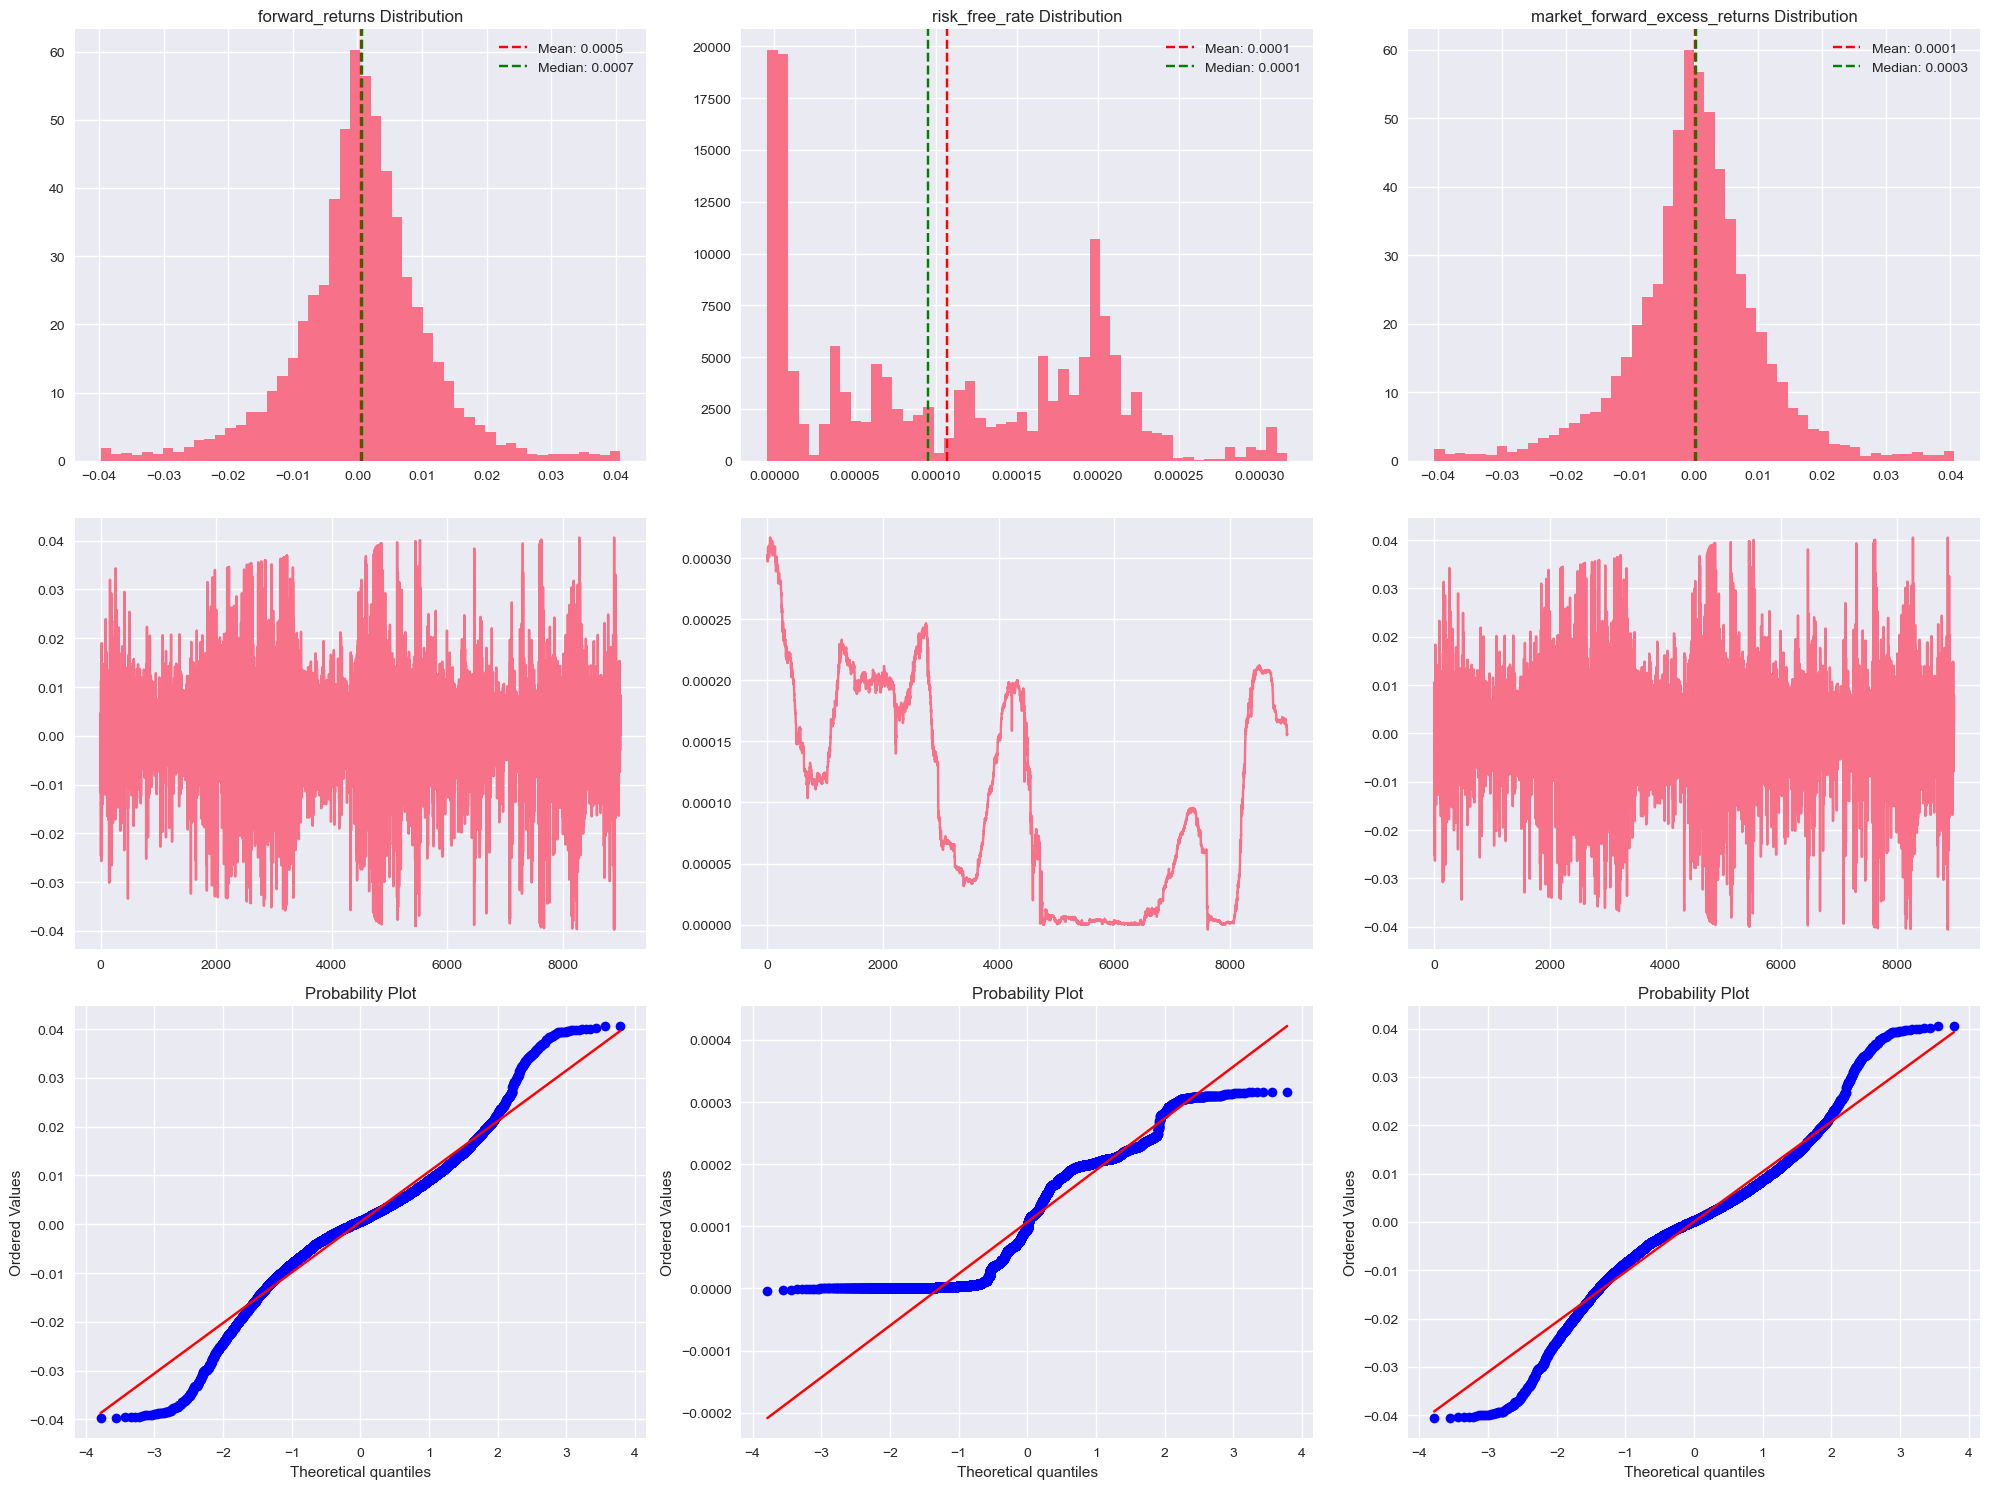

In [114]:
target_cols = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
target_cols = [col for col in target_cols if col in df.columns]

fig, axes = plt.subplots(3, len(target_cols), figsize=(20, 15))

for i, col in enumerate(target_cols):
    data = df[col].dropna()
    
    print(f'\n{col.upper()} Statistics:')
    print(f'Count: {len(data)}')
    print(f'Mean: {data.mean():.4f}')
    print(f'Std: {data.std():.4f}')
    print(f'Skewness: {data.skew():.4f}')
    print(f'Kurtosis: {data.kurtosis():.4f}')
    
    # distributions plots
    axes[0, i].hist(data, bins=50, density=True)
    axes[0, i].axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.4f}')
    axes[0, i].axvline(data.median(), color='green', linestyle='--', label=f'Median: {data.median():.4f}')
    axes[0, i].set_title(f'{col} Distribution')
    axes[0, i].legend()


    # timeseries plots
    axes[1, i].plot(df['date_id'], df[col])

    # Q-Q plots (normality assumption)
    stats.probplot(data, dist="norm", plot=axes[2, i])

    # Statistical tests
    jb_stat, jb_pvalue = jarque_bera(data)
    print(f"Jarque-Bera test p-value: {jb_pvalue:.6f} ({'Normal' if jb_pvalue > 0.05 else 'Not Normal'})")

plt.tight_layout()
plt.show()

### Interpretation



#### Forward Returns
- Distributed around 0.0005
- Standard deviation ~1%
- Kurtosis ~2.2, lighter tails compared to normal distribution
- Not normally distributed

#### Risk Free Rate
- Mean ~0.0001
- Standard deviation ~0.0001
- Kurtosis ~-1.26, thin tails
- Not normally distributed

#### Market Forward Excess Returns
- Distributed around 0.0001
- Standard deviation ~1%
- Kurtosis ~2.24, light tails
- Not normally distributed

**Key Insight:**
- **Cannot Use models with normality assumption**
- Huber might lowk be goated

## Feature Analysis

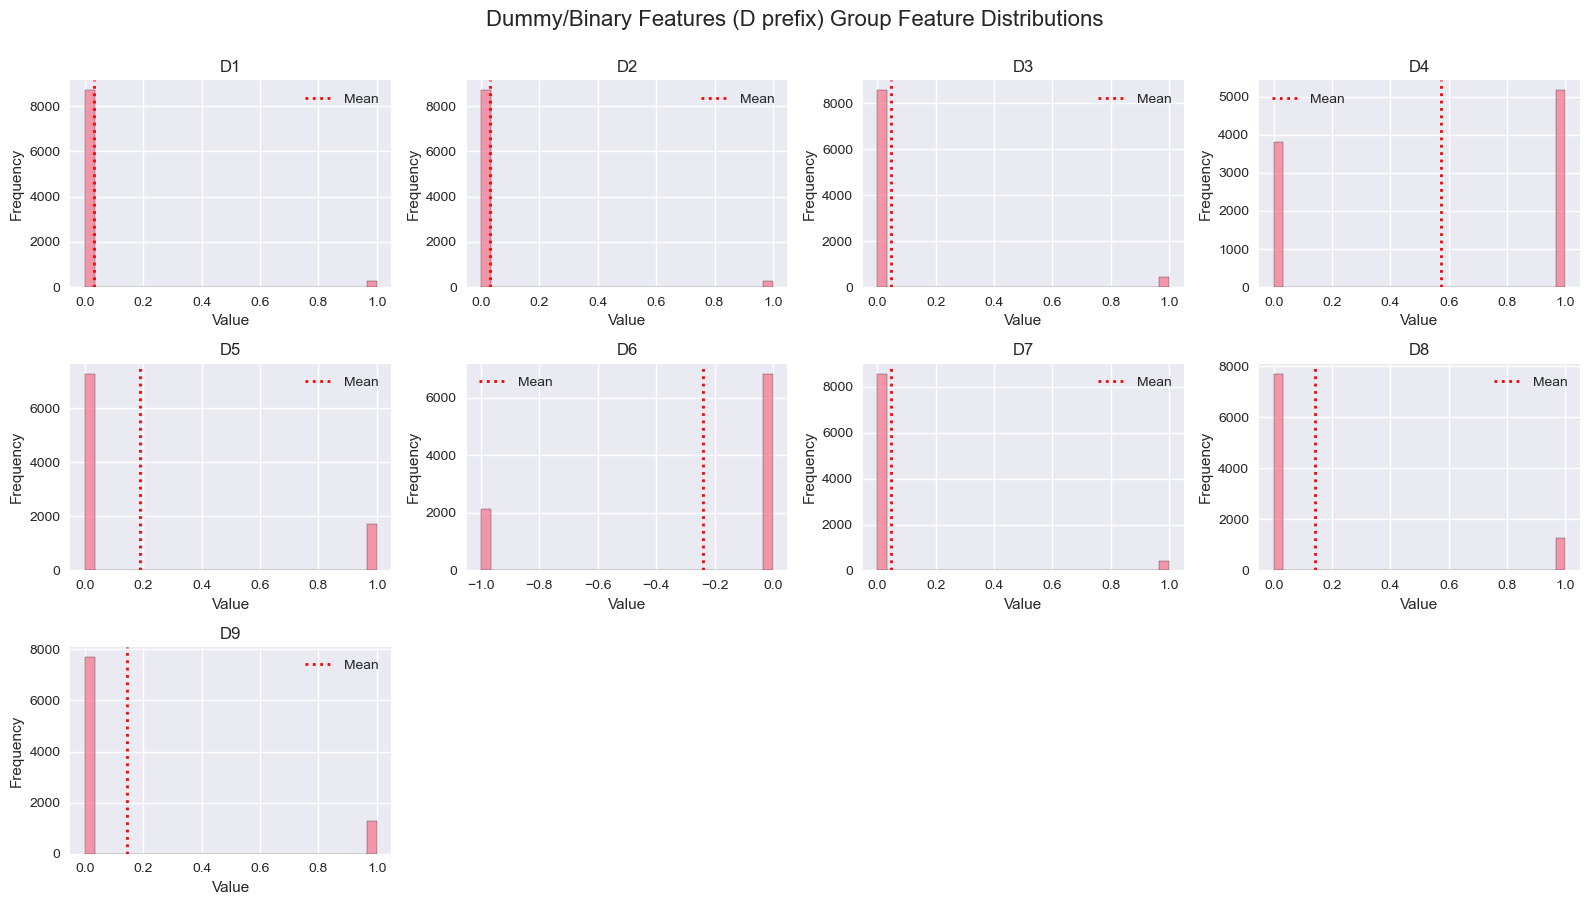

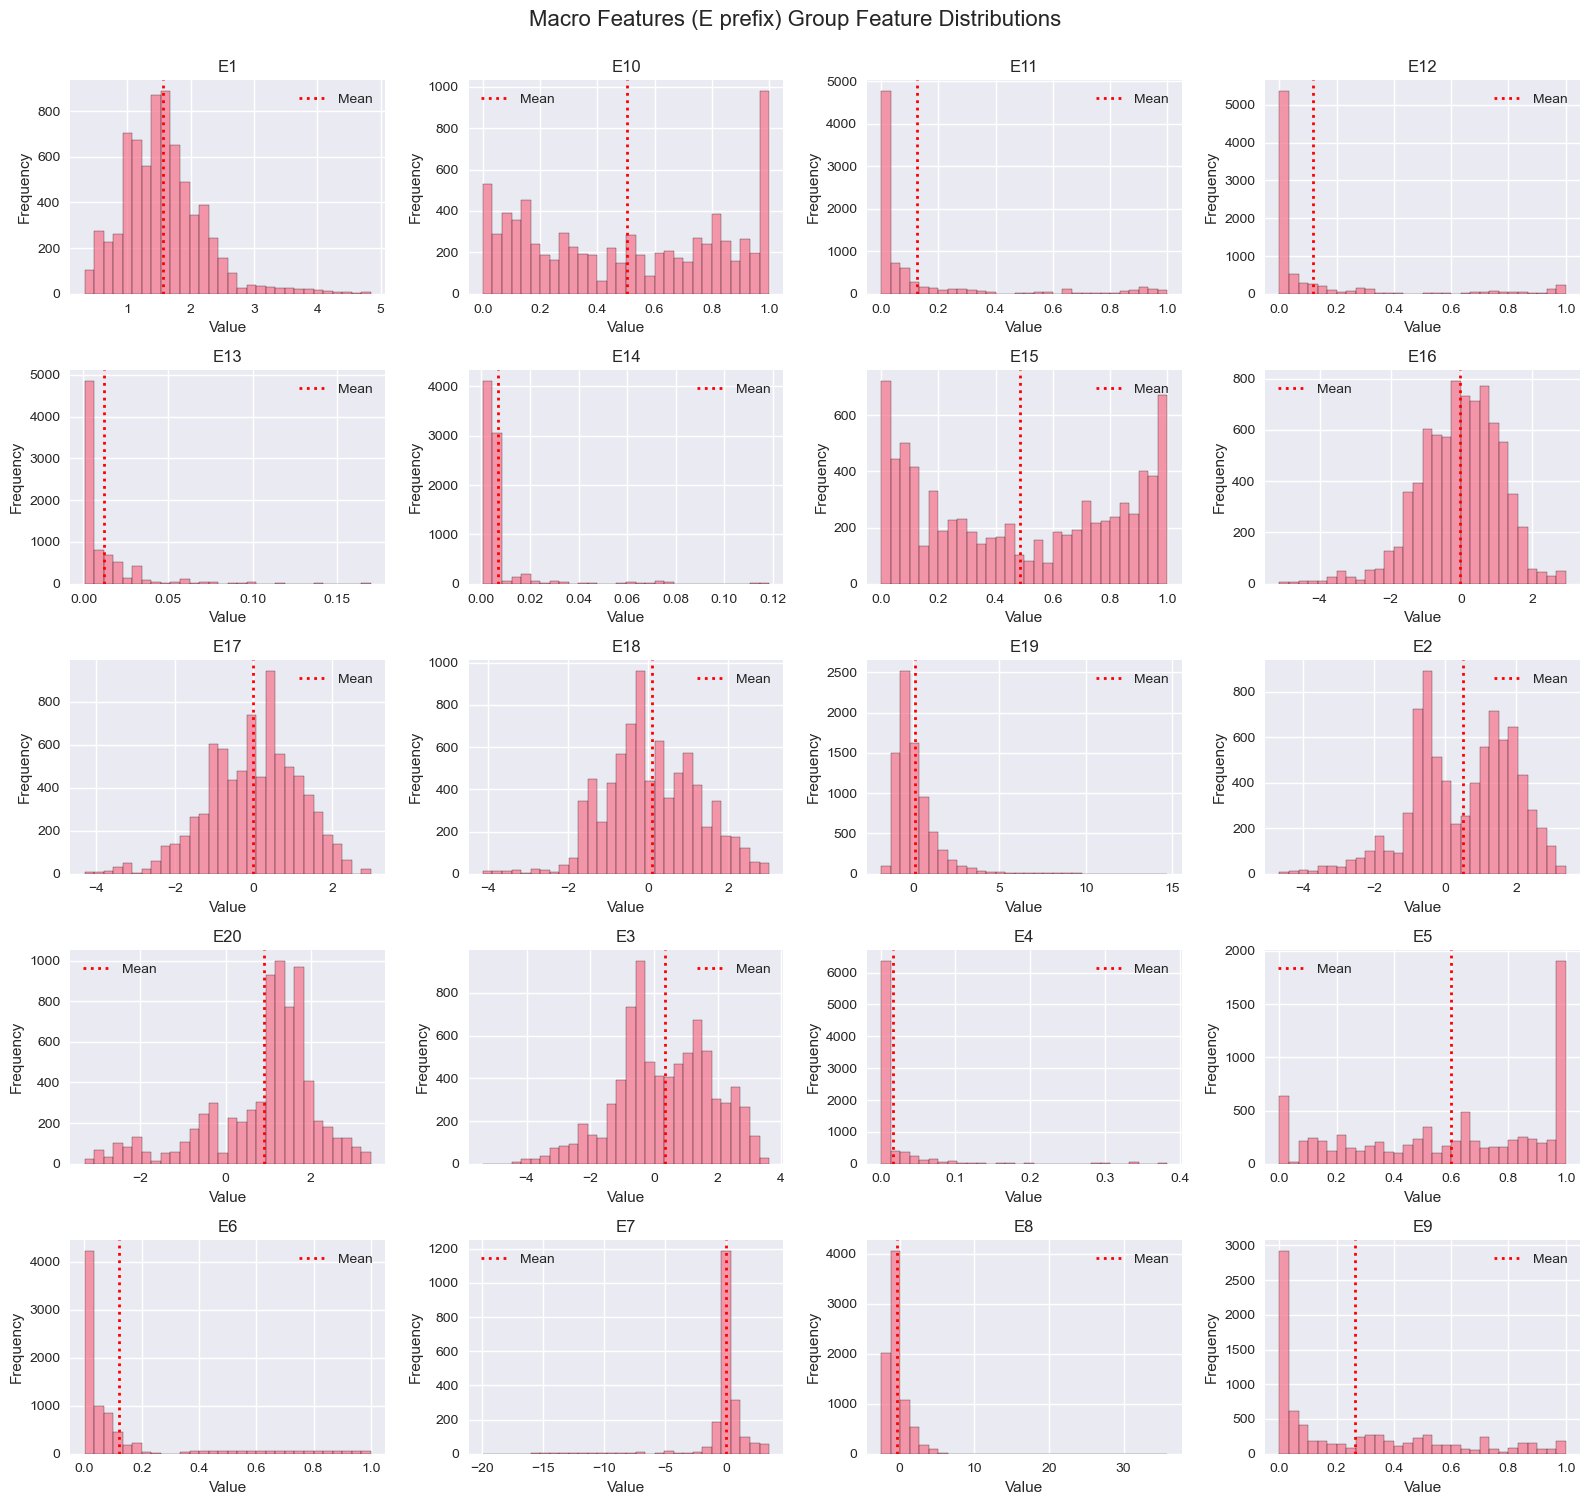

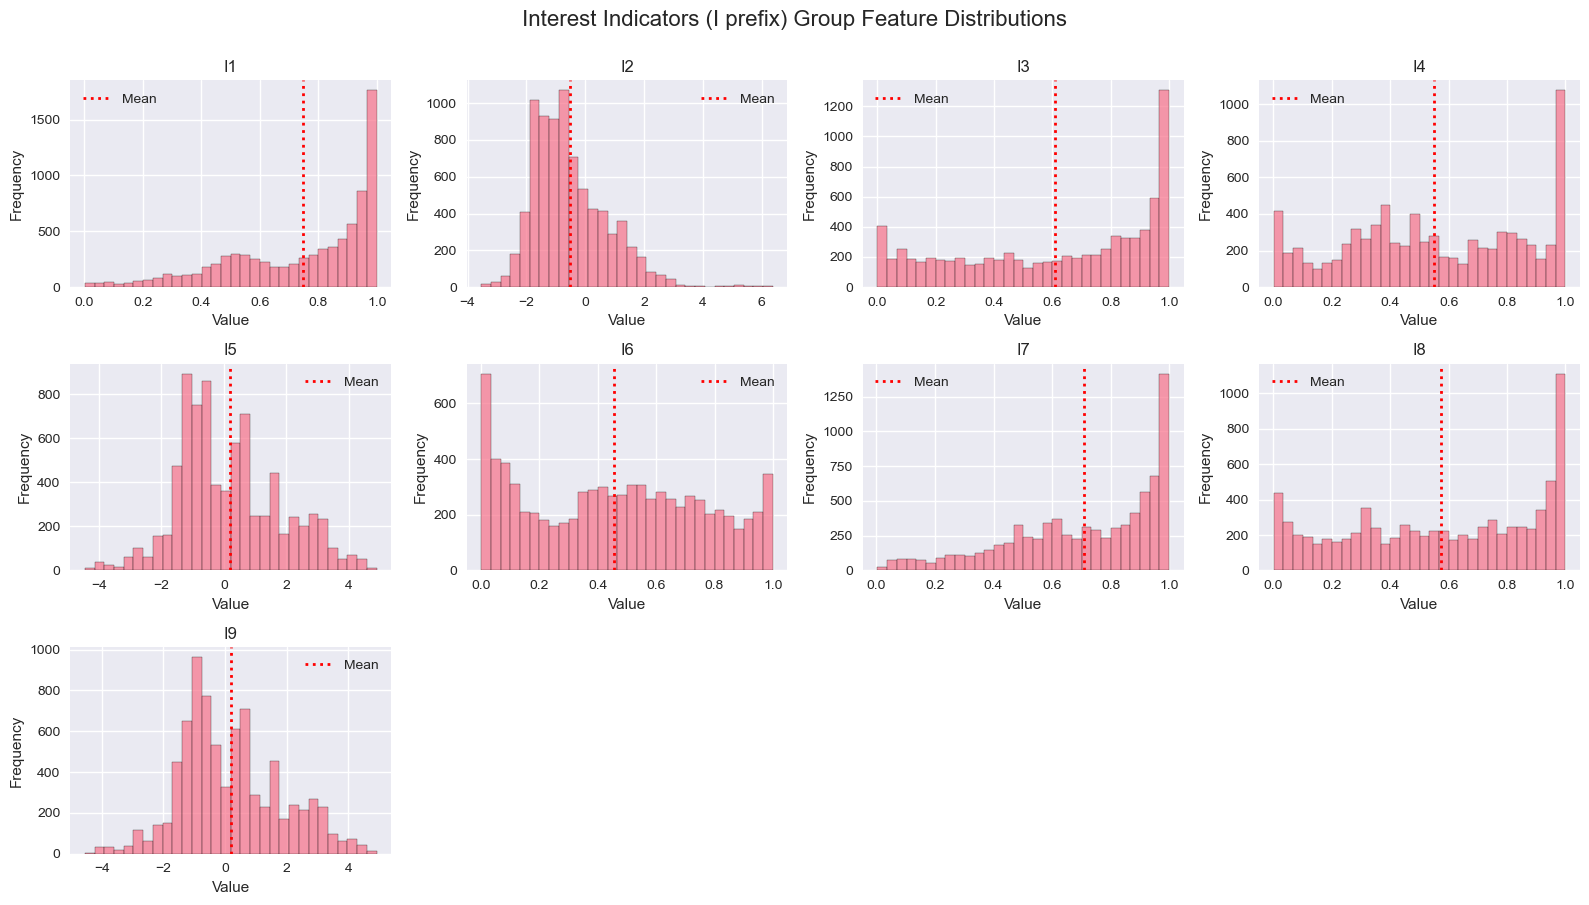

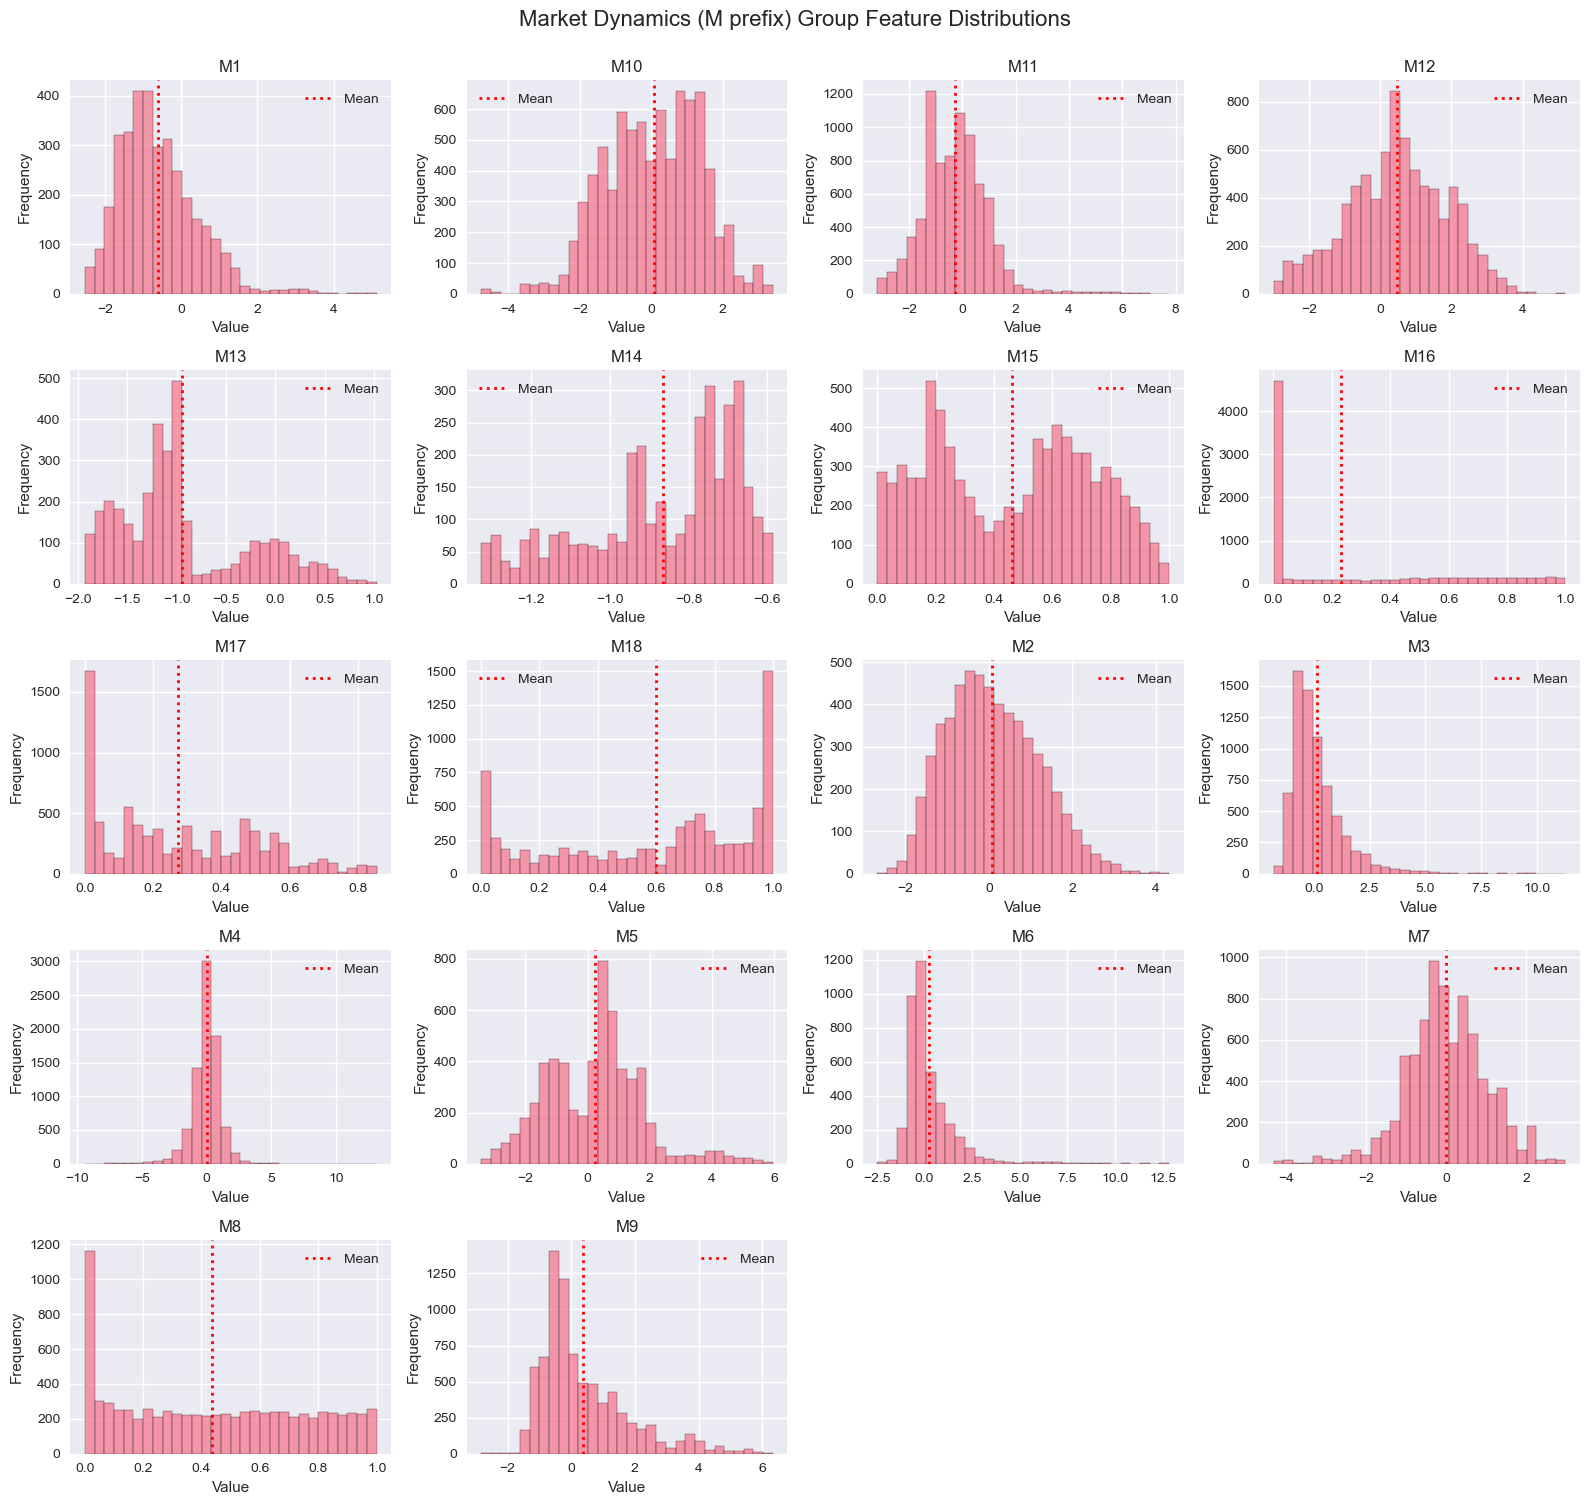

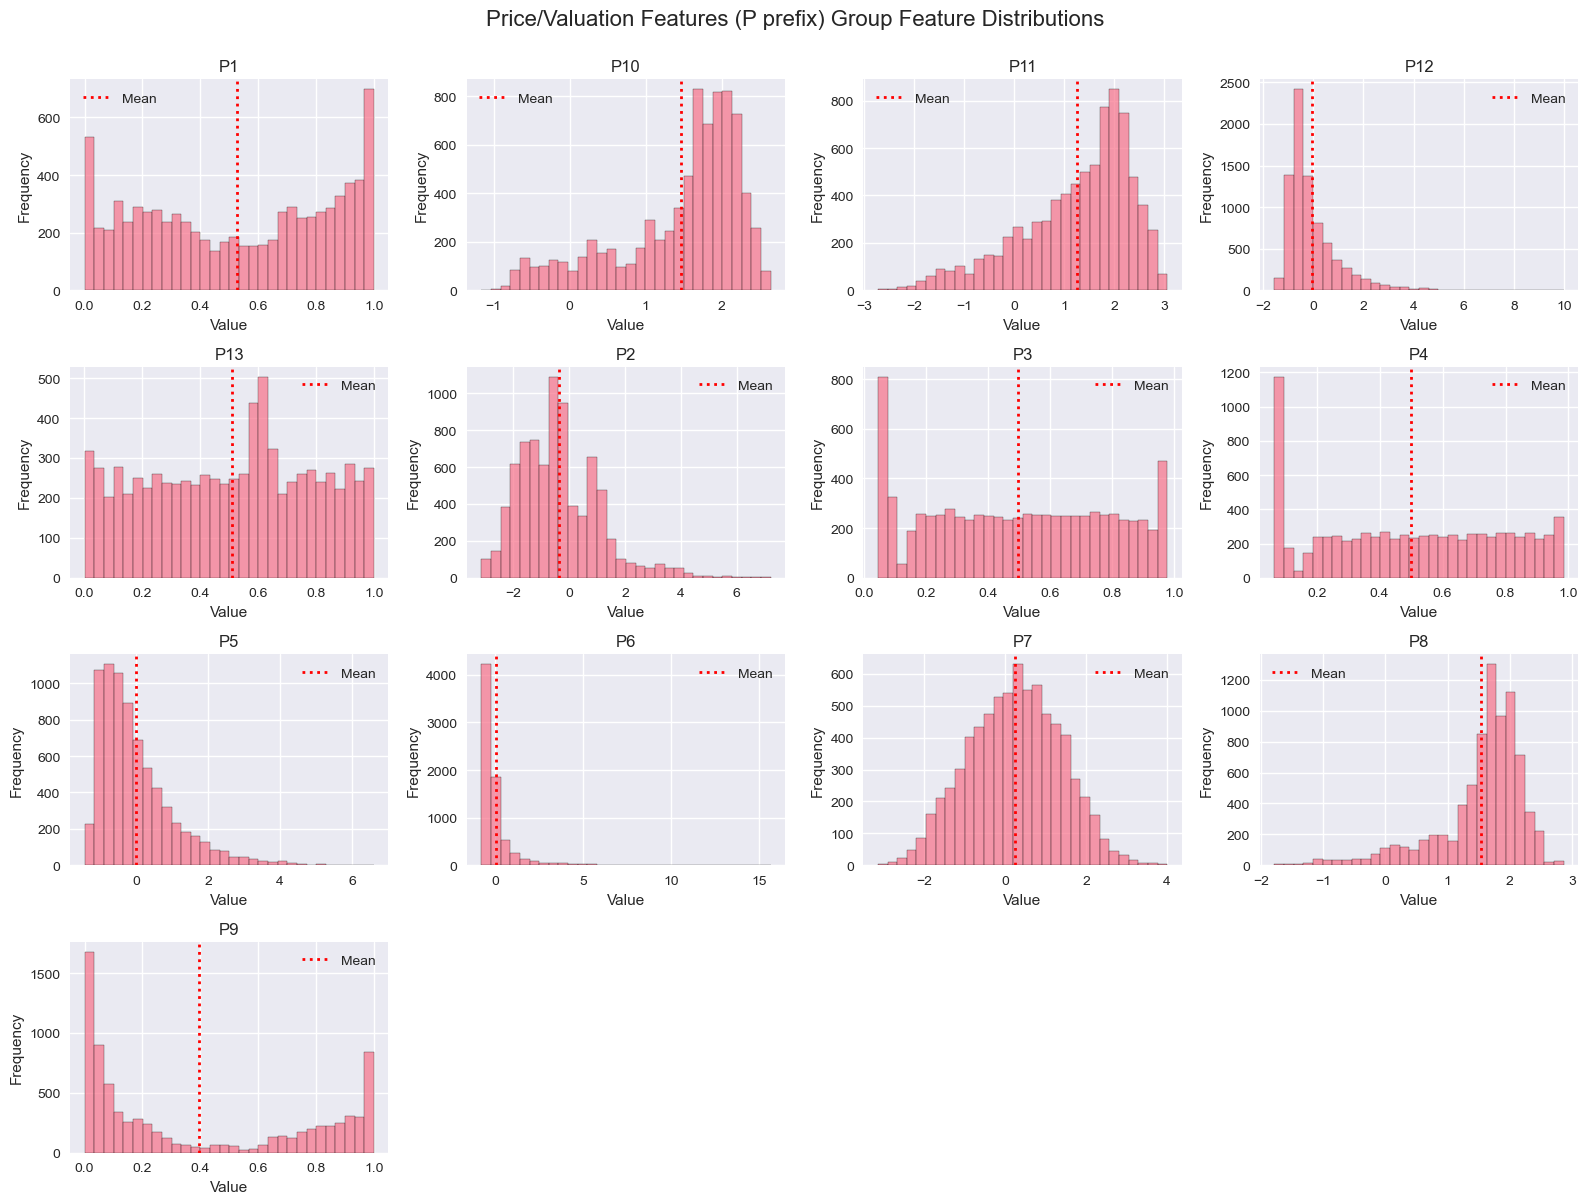

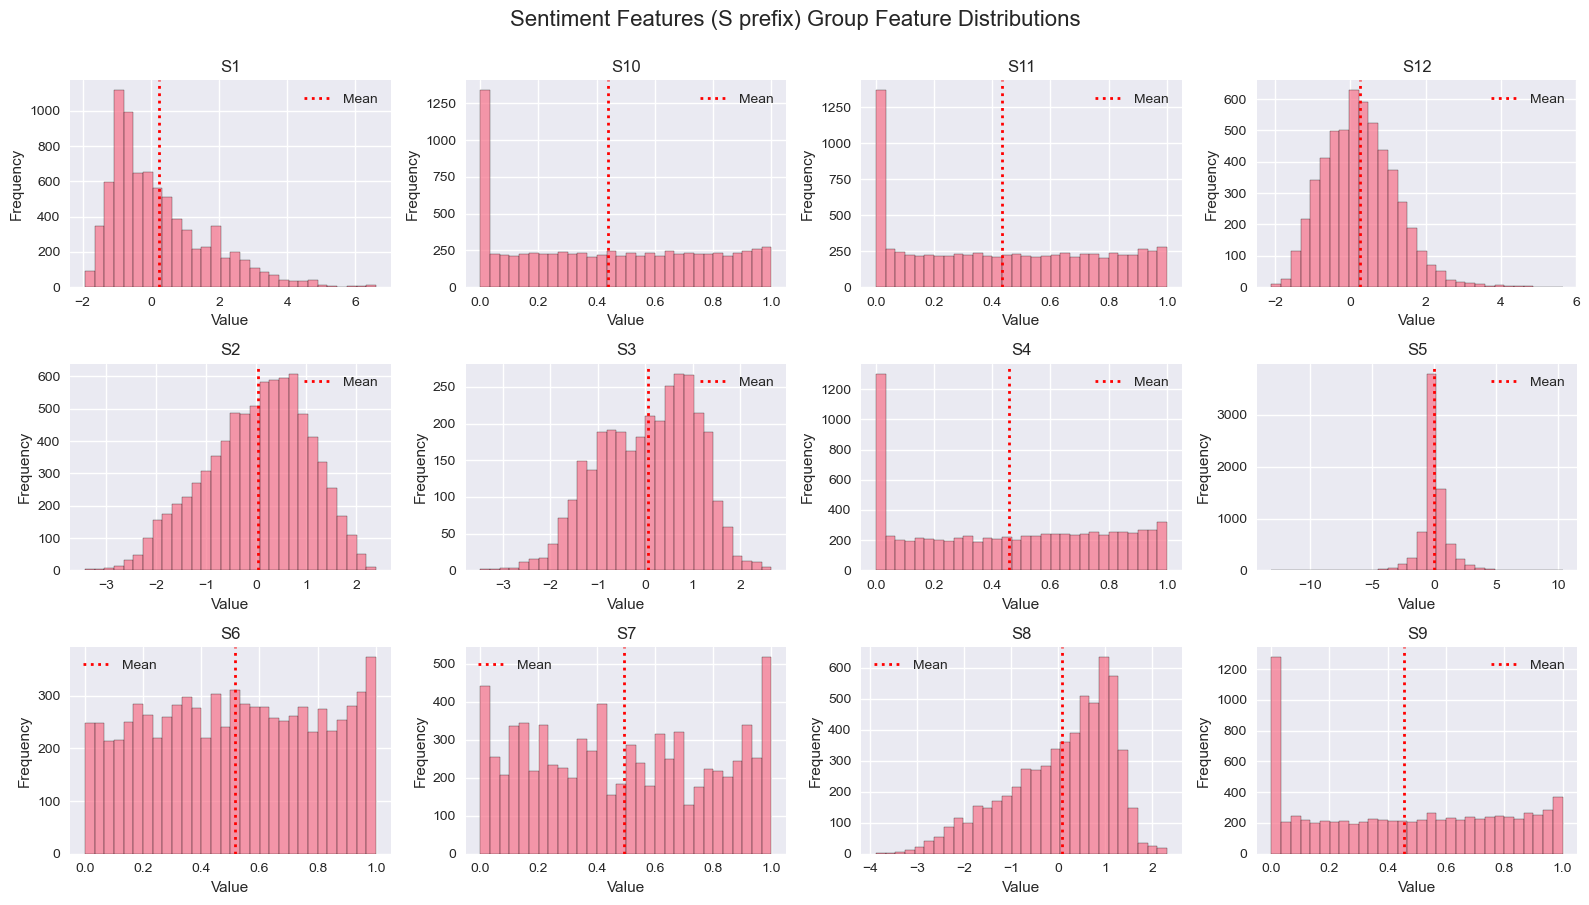

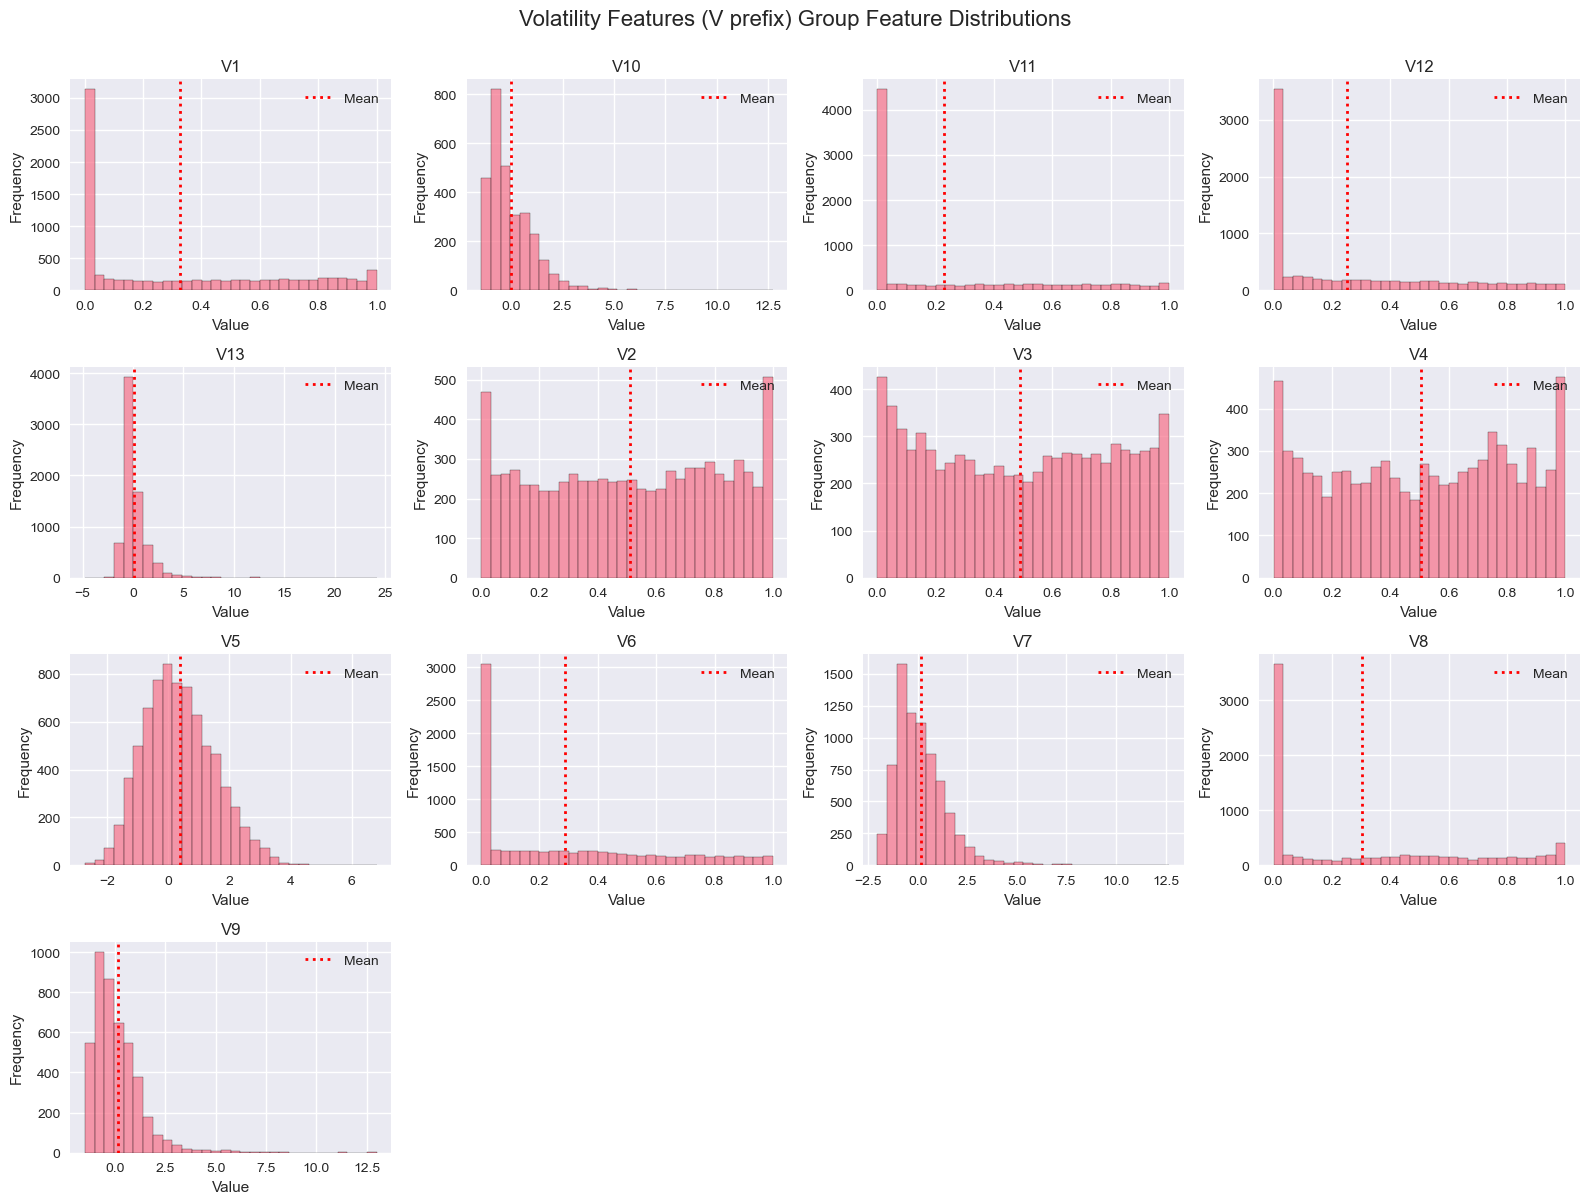

In [121]:
# Define feature groups
feature_groups = {
    'Dummy/Binary Features (D prefix)': [col for col in df.columns if col.startswith('D') and col[1:].isdigit()],
    'Macro Features (E prefix)': [col for col in df.columns if col.startswith('E') and col[1:].isdigit()],
    'Interest Indicators (I prefix)': [col for col in df.columns if col.startswith('I') and col[1:].isdigit()],
    'Market Dynamics (M prefix)': [col for col in df.columns if col.startswith('M') and col[1:].isdigit()],
    'Price/Valuation Features (P prefix)': [col for col in df.columns if col.startswith('P') and col[1:].isdigit()],
    'Sentiment Features (S prefix)': [col for col in df.columns if col.startswith('S') and col[1:].isdigit()],
    'Volatility Features (V prefix)': [col for col in df.columns if col.startswith('V') and col[1:].isdigit()]
}

# Plot each group separately
for group_name, features in feature_groups.items():
    n_features = len(features)

    # Calculate grid size
    n_cols = 4
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    fig.suptitle(f'{group_name} Group Feature Distributions', fontsize=16, y=1.00)

    # Flatten axes array for easier iteration
    axes = axes.flatten() if n_features > 1 else [axes]
    

    for idx, feature in enumerate(features):
        data = df[feature].dropna()
        axes[idx].hist(df[feature].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].axvline(data.mean(), color='red', linestyle=':', linewidth=2, label='Mean')
        axes[idx].set_title(feature)
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend()

    # Hide unused subplots
    for idx in range(n_features, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

## Stationarity Assumption

### Testing for stationarity assumption (Response)

#### Hypothesis

$H_0: \text{The forward excess-returns series has a unit root, i.e., } \rho = 1 \text{ in } y_t = \rho y_{t-1} + \epsilon_t$

$H_a: \text{The forward excess-returns series does not have a unit root, i.e., } \lvert \rho \rvert < 1 \text{ in } y_t = \rho y_{t-1} + \epsilon_t$

In [106]:
from statsmodels.tsa.stattools import adfuller

res = adfuller(df['market_forward_excess_returns'])
print(f'ADF Statistic: {res[0]:.4f}')
print(f'p-value: {res[1]:.4f}')

ADF Statistic: -17.5017
p-value: 0.0000


$\text{p-value} < \alpha = 0.05 \therefore \text{ reject } H_0, \text{ the forward excess-returns series is stationary}$

### Testing for stationarity assumption (Features)

  #### Hypothesis

  For each feature series in the dataset,

  $H_0: \text{The feature series has a unit root, i.e., }
  \rho = 1 \text{ in } X_t = \rho X_{t-1} + \epsilon_t$

  $H_a: \text{The feature series does not have a unit root,
  i.e., } |\rho| < 1 \text{ in } X_t = \rho X_{t-1} +
  \epsilon_t$


In [107]:
alpha = 0.05
non_stationary_features = {}

for feature in df.columns[1:len(df.columns)-1]: # for all features except date & response
    col = df[feature].dropna()
    res = adfuller(col)
    if res[1] >= alpha: 
        non_stationary_features[feature] = (res[0], res[1])
        print(f'feature: {feature} failed to reject with p-value: {res[1]} and ADF Statistic: {res[0]}')

feature: E10 failed to reject with p-value: 0.11040359975733177 and ADF Statistic: -2.521188833210607
feature: E11 failed to reject with p-value: 0.08364751381508939 and ADF Statistic: -2.64710275036733
feature: E12 failed to reject with p-value: 0.46753467177830943 and ADF Statistic: -1.629916020551717
feature: E2 failed to reject with p-value: 0.10936270833507022 and ADF Statistic: -2.5256275989800208
feature: E20 failed to reject with p-value: 0.2731916235368921 and ADF Statistic: -2.0308985092912932
feature: E3 failed to reject with p-value: 0.07020170416098 and ADF Statistic: -2.7226407392953274
feature: E5 failed to reject with p-value: 0.24484545498133115 and ADF Statistic: -2.099177516164839
feature: E6 failed to reject with p-value: 0.07479476364775849 and ADF Statistic: -2.695645843827929
feature: E9 failed to reject with p-value: 0.6308723189713663 and ADF Statistic: -1.296280385595506
feature: I4 failed to reject with p-value: 0.1767687057080296 and ADF Statistic: -2.285251

In [108]:
print(f'Number of non-stationary features: {len(non_stationary_features)}')
print(f'{(len(non_stationary_features)/(len(df.columns)-1)):.4f}% of features non-stationary')


Number of non-stationary features: 24
0.2474% of features non-stationary


In [109]:
for prefix in ['D', 'E', 'I', 'M', 'P', 'S', 'V']:
    all_features = [col for col in df.columns if
    col.startswith(prefix) and col[1:].isdigit()]
    non_stat = [f for f in all_features if f in non_stationary_features]

    total = len(all_features)
    count = len(non_stat)
    pct = count / total * 100 if total > 0 else 0

    print(f"{prefix}: {count}/{total} ({pct:.1f}%) non-stationary")


D: 0/9 (0.0%) non-stationary
E: 9/20 (45.0%) non-stationary
I: 4/9 (44.4%) non-stationary
M: 5/18 (27.8%) non-stationary
P: 3/13 (23.1%) non-stationary
S: 0/12 (0.0%) non-stationary
V: 2/13 (15.4%) non-stationary


### Conclusion

Response is stationary so no additional work will need to be done to satisfy the assumption. 

24 of the features (~24%) will need to be adjusted or removed in order to satisft the assumption.

Non-stationary features: ['E10', 'E11', 'E12', 'E2', 'E20', 'E3', 'E5', 'E6', 'E9', 'I4', 'I5', 'I8', 'I9', 'M13', 'M14', 'M16', 'M17', 'M18', 'P10', 'P11', 'P9', 'V11', 'V8', 'risk_free_rate']

### Solution for non-stationary features

- E (Macro features) 9/20 non-stationary
    - log difference (generally better for economic data)
- I (Interest indicators) 4/9 non-stationary
    - difference
- M (Market dynamics) 5/18 non-stationary
    - difference
- P (Price/Valuation) 3/13 non-stationary
    - difference
    - z-score potentially
- V (Volatility) 2/13 non-stationary
    - log difference (standard in vol modeling)

**Note:** some p-values are exceptionally close to $\alpha$, potentially could use these features without modifying

### Multicollinearity Diagnostic

In [110]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = [col for col in df.columns if col not in ['date_id', 'forward_returns', 'risk_free_rate']]
df_features = df[features].dropna()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = df_features.columns
vif_data["VIF"] =[variance_inflation_factor(df_features.values, i)
                    for i in
range(len(df_features.columns))]

# Sort by VIF (highest first)
vif_data = vif_data.sort_values('VIF', ascending=False)

# Display results
print("\nVariance Inflation Factors:")

vif_data


Variance Inflation Factors:


,Feature,VIF
0,D1,inf
1,D2,inf
37,I9,2.074749e+04
33,I5,2.045771e+04
58,P11,2.961379e+03
...,...,...
5,D6,1.880317e+00
59,P12,1.509497e+00
6,D7,1.162029e+00
2,D3,1.134475e+00



High Correlations (>0.8):
   Feature 1 Feature 2  Correlation
0         D1        D2     1.000000
10        I5        I9     0.999689
20       V10        V9     0.985185
24        V7        V9     0.978070
1        E11       E12     0.974322
4         E2        E3     0.961338
23        V2        V4     0.952516
16       S10       S11     0.944463
14       P10       P11     0.936428
12       M16       V11     0.934983
19       V10        V7     0.934138
2        E16       E17     0.918062
13        M2        P7    -0.907963
8         E3        P2    -0.895476
18       S11        S4     0.885648
6         E2        P2    -0.876170
7         E3       P11     0.870070
5         E2       P11     0.866920
11        M1       V10     0.856546
21       V13        V7     0.847038
17       S10        S4     0.839617
3        E19        V7     0.830119
9         I4        I8     0.829763
15       P10        P8     0.806819
22        V2        V3     0.803247


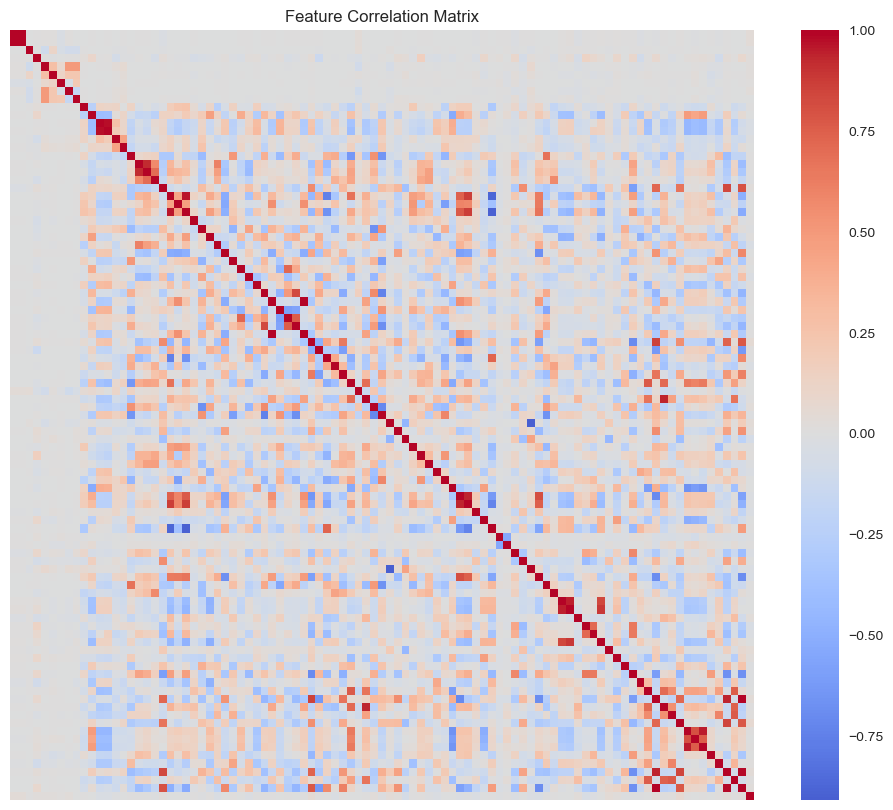

In [111]:
import seaborn as sns

corr_matrix = df[features].corr()

threshold = 0.8
high_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation',
ascending=False, key=abs)
print(f"\nHigh Correlations (>{threshold}):")
print(high_corr_df)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
            xticklabels=False, yticklabels=False)
plt.title('Feature Correlation Matrix')
plt.show()

#### Interpretation

